In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numba import jit
from scipy.integrate import solve_ivp
import seaborn as sns

# Full 

In [107]:
def leaky_cons_atc(t,z,a,Ka,KR,KQ,KC,C0,g1,g2,a1,a2,p1,p2,q,NT):
    #gamma=hill(z[3]/KR,q)   #z=[M,D,Q,R,R2,R3,R4,C] 
    eta=hill(a/Ka,q)        #  [0,1,2,3, 4, 5, 6,7]
    epsilon=hill(z[2]/KQ,q)
    zeta = hill(C0/KC,q)
    gamma=hill(z[4]/KR,q)
    N1=g1*(1-(1-eta)*gamma)*z[0]-(g1*z[0]+g2*z[1])*(z[0]/(z[0]+z[1]))*np.heaviside(z[0]+z[1]-NT,0)
    N2=g1*(1-eta)*gamma*z[0]+g2*z[1]-(g1*z[0]+g2*z[1])*(z[1]/(z[0]+z[1]))*np.heaviside(z[0]+z[1]-NT,0)
    Q=(p1*(1-eta)*(1-a1)+p1*a1)*z[1]-(g1*z[0]+g2*z[1])*(z[2]/(z[0]+z[1]))*np.heaviside(z[0]+z[1]-NT,0)
    R=(p2*(1-epsilon)*(1-a2)+p2*a2)-g1*z[3]+2*k2m*z[4]-2*k2p*z[3]**2
    R2=k2p*z[3]**2+k3m*z[5]+k3m*z[5]-2*k3p*z[4]*z[7]-(k2m+g1)*z[4]
    R3=2*k3p*z[4]*z[7]+2*k4m*z[6]-k4p*z[5]*z[7]-(k3m+g1)*z[5]
    R4=k4p*z[5]*z[7]-(2*k4m+g1)*z[6]
    C=k*(C0-z[7])+k3m*z[5]+2*k4m*z[6]-2*k3p*z[4]*z[7]-k4p*z[5]*z[7]-g1*z[7]
    return [N1,N2,Q,R,R2,R3,R4,C]

def hill(x,q):
    return (1+x**q)**(-1)

def plot_model3(t,z1,a,i):
    axes[i,0].plot(t,z1[0]/NT,label='mother',color='C0',linewidth=2)
    #axes[i,0].plot(t,z1[1]/NT,label='daughter',color='C1')
    axes[i,0].set_ylabel(tag[i])
    axes[i,1].plot(t,z1[2]/KQ,label='QS',color='purple',linewidth=2)
    axes[i,2].plot(t,z1[4]/KR,label='tetR',color='green',linewidth=2) 
    #gamma=hill(z1[3]/KR,q)   #z=[M,D,Q,R]
    gamma=hill(z1[4]/KR,q)
    eta=hill(a/Ka,q)
    prob=(1-eta)*gamma
    axes[i,3].plot(t,prob,label=r'Prob. of APP: $(1-\eta)\gamma$',color='k',linewidth=2)
    axes[i,3].text(T+1,prob[-1],"{:.2f}".format(prob[-1]),color='k')
    #print(((1-eta)*gamma)[-1])
    for j in range(4):
        axes[i,j].spines['right'].set_color('none')
        axes[i,j].spines['top'].set_color('none')
        if i<2:
            axes[i,j].set_xticklabels([])
        axes[i,j].set_xticks([0,T/4,T/2,3*T/4,T])
    axes[i,0].set_ylim([0,1.1])
    axes[i,0].set_yticks([0,0.5,1])
    axes[i,1].set_ylim([0,6])
    axes[i,1].set_yticks([0,3,6])
    axes[i,2].set_ylim([0,6])
    axes[i,2].set_yticks([0,3,6])
    axes[i,3].set_ylim([0,1.1])
    axes[i,3].set_yticks([0,0.5,1])
    axes[i,0].vlines(40,0,1,color='r',linestyle='--')
    axes[i,0].vlines(5,0,1,color='r',linestyle='--')
    if i==2:
        axes[0,0].legend(bbox_to_anchor=(1, 1.7),ncol=2)
        axes[0,1].legend(bbox_to_anchor=(1, 1.7),ncol=1)
        axes[0,2].legend(bbox_to_anchor=(1, 1.7),ncol=1)
        axes[0,3].legend(bbox_to_anchor=(1, 1.7),ncol=1)
    plt.tight_layout(h_pad=1,w_pad=1)
    return None

def plot_C0():
    plt.bar(tag,np.array(init_C)/KC,color='slategrey',width=0.5)
    ax = plt.gca()
    #ax.set_yscale('log')
    ax.set_ylabel(r'$\dfrac{C_0}{K_C}$', rotation=0)
    ax.hlines(1,-0.5,4,color='r')
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim([0,2])
    ax.set_yticks([0,1,2])
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    
    space=5
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        va = 'bottom'
        if y_value < 0:
            space *= -1
            va = 'top'
        label = "{:.1f}".format(y_value)
        ax.annotate(label,(x_value, y_value),xytext=(0, space),textcoords="offset points",ha='center',va=va)
    return None

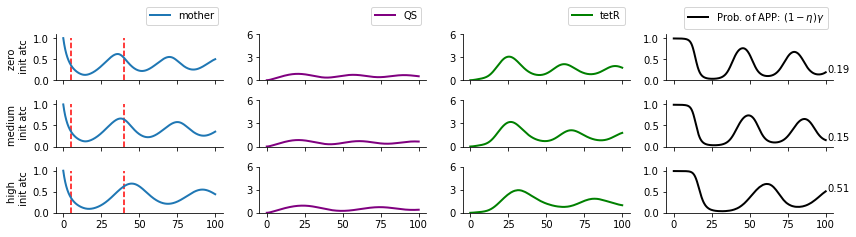

In [108]:
Ka=1e3
KQ=1e7
KR=5e-3 #for R2
#KR=1e-2 #for R1
KC=8e-1

NT=1e8
init_m=NT
init_d=NT-init_m
init_R=KR
init_Q=KR/2
init_C=KC*np.array([0, 0.3, 2])

#ODE model parameters
g1= 0.27 #Mother cell   #(np.log(2)/20)*60   
g2= 0.11 #Daughter cell #(np.log(2)/25)*60
p1=0.015 #Quorum sensing mol
p2=0.07   #tetR
a1=0.01 #0.03      #QS leak
a2=0.1 #0.15  #tetR leak

q=3
a=5*Ka

k2p =1
k2m =0.06   #***
k3p =1
k3m =0.36   #*** 
k4p =1
k4m =0.72   #***
k =0.19


T=100                                     
t = np.linspace(0, T, 10000)
f,axes = plt.subplots(3,4,figsize=(12,3.5))#,gridspec_kw={'width_ratios': [1, 1],'height_ratios': [3, 1,3,1]})
#f.text(0.45,1,'Model 3',fontsize=20)#f.text(0.45,1,'Leaky tetR',fontsize=20)
tag  =['zero \n init atc','medium \n init atc','high \n init atc']
for i in range(3):
    sol = solve_ivp(lambda t, z: leaky_cons_atc(t, z,a, Ka,KR,KQ,KC,init_C[i],g1,g2,a1,a2,p1,p2,q,NT), [0, T], [init_m, init_d, init_Q, init_R,0,0,0,0],dense_output=True)
    z1 = sol.sol(t)
    plot_model3(t,z1,a,i)
#f.savefig('leaky_atc_tetR.jpg', format='jpg', dpi=500,bbox_inches="tight")

In [ ]:
plt.plot(t,z1[7])

# R2 tracking

In [116]:
def leaky_cons_atc3(t,z,a,Ka,KR,KQ,KC,C0,g1,g2,a1,a2,p1,p2,q,NT):
    gamma=hill(z[3]/KR,q)   #z=[M,D,Q,R] [0,1,2,3]
    eta=hill(a/Ka,q)
    epsilon=hill(z[2]/KQ,q)
    zeta = hill(C0/KC,q)
    N1=g1*(1-(1-eta)*gamma)*z[0]-(g1*z[0]+g2*z[1])*(z[0]/(z[0]+z[1]))*np.heaviside(z[0]+z[1]-NT,0)
    N2=g1*(1-eta)*gamma*z[0]+g2*z[1]-(g1*z[0]+g2*z[1])*(z[1]/(z[0]+z[1]))*np.heaviside(z[0]+z[1]-NT,0)
    Q=(p1*(1-eta)*(1-a1)+p1*a1)*z[1]-(g1*z[0]+g2*z[1])*(z[2]/(z[0]+z[1]))*np.heaviside(z[0]+z[1]-NT,0)
    R2=0.5*(p2*(1-epsilon)*(1-a2)+p2*a2)-g1*z[3]-(2*k3p*k*C0*z[3])/(k+4*k3p*z[3])
    return [N1,N2,Q,R2]

def hill(x,q):
    return (1+x**q)**(-1)

def plot_model3(t,z1,a,i):
    axes[i,0].plot(t,z1[0]/NT,label='mother',color='C0',linewidth=2)
    #axes[i,0].plot(t,z1[1]/NT,label='daughter',color='C1')
    axes[i,0].set_ylabel(tag[i])
    axes[i,1].plot(t,z1[2]/KQ,label='QS',color='purple',linewidth=2)
    axes[i,2].plot(t,z1[3]/KR,label='tetR',color='green',linewidth=2) 
    gamma=hill(z1[3]/KR,q)   #z=[M,D,Q,R]
    eta=hill(a/Ka,q)
    prob=(1-eta)*gamma
    axes[i,3].plot(t,prob,label=r'Prob. of APP: $(1-\eta)\gamma$',color='k',linewidth=2)
    axes[i,3].text(T+1,prob[-1],"{:.2f}".format(prob[-1]),color='k')
    #print(((1-eta)*gamma)[-1])
    for j in range(4):
        axes[i,j].spines['right'].set_color('none')
        axes[i,j].spines['top'].set_color('none')
        if i<2:
            axes[i,j].set_xticklabels([])
        axes[i,j].set_xticks([0,T/2,T])
    axes[i,0].set_ylim([0,1.1])
    axes[i,0].set_yticks([0,0.5,1])
    axes[i,1].set_ylim([0,6])
    axes[i,1].set_yticks([0,3,6])
    axes[i,2].set_ylim([0,6])
    axes[i,2].set_yticks([0,3,6])
    axes[i,3].set_ylim([0,1.1])
    axes[i,3].set_yticks([0,0.5,1])
    if i==2:
        axes[0,0].legend(bbox_to_anchor=(1, 1.7),ncol=2)
        axes[0,1].legend(bbox_to_anchor=(1, 1.7),ncol=1)
        axes[0,2].legend(bbox_to_anchor=(1, 1.7),ncol=1)
        axes[0,3].legend(bbox_to_anchor=(1, 1.7),ncol=1)
    plt.tight_layout(h_pad=1,w_pad=1)
    return None

def plot_C0():
    plt.bar(tag,np.array(init_C)/KC,color='slategrey',width=0.5)
    ax = plt.gca()
    #ax.set_yscale('log')
    ax.set_ylabel(r'$\dfrac{C_0}{K_C}$', rotation=0)
    ax.hlines(1,-0.5,4,color='r')
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim([0,2])
    ax.set_yticks([0,1,2])
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    
    space=5
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        va = 'bottom'
        if y_value < 0:
            space *= -1
            va = 'top'
        label = "{:.1f}".format(y_value)
        ax.annotate(label,(x_value, y_value),xytext=(0, space),textcoords="offset points",ha='center',va=va)
    return None

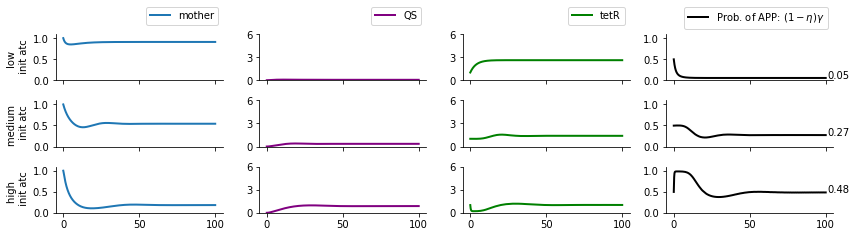

In [119]:
Ka=1e3
KQ=1e7
KR=5e-3 #for R2
#KR=1e-2 #for R1
KC=8e-1

NT=1e8
init_m=NT
init_d=NT-init_m
init_R=KR
init_Q=KR/2
init_C=KC*np.array([0, 0.3, 2])

#ODE model parameters
g1= 0.27 #Mother cell   #(np.log(2)/20)*60   
g2= 0.11 #Daughter cell #(np.log(2)/25)*60
p1=0.015 #Quorum sensing mol
p2=0.07   #tetR
a1=0.01 #0.03      #QS leak
a2=0.1 #0.15  #tetR leak

q=3
a=5*Ka

k2p =1
k2m =0.06   #***
k3p =1
k3m =0.36   #*** 
k4p =1
k4m =0.72   #***
k =0.19

T=100                                   
t = np.linspace(0, T, 10000)
f,axes = plt.subplots(3,4,figsize=(12,3.5))#,gridspec_kw={'width_ratios': [1, 1],'height_ratios': [3, 1,3,1]})
#f.text(0.45,1,'Model 3',fontsize=20)#f.text(0.45,1,'Leaky tetR',fontsize=20)
tag  =['low \n init atc','medium \n init atc','high \n init atc']
for i in range(3):
    sol = solve_ivp(lambda t, z: leaky_cons_atc3(t, z,a, Ka,KR,KQ,KC,init_C[i],g1,g2,a1,a2,p1,p2,q,NT), [0, T], [init_m, init_d, init_Q, init_R],dense_output=True)
    z1 = sol.sol(t)
    plot_model3(t,z1,a,i)
f.savefig('leaky_atc_tetR3.jpg', format='jpg', dpi=500,bbox_inches="tight")

In [58]:
#convert x M-1 sec-1 to (molecules/L)-1 hr-1
x=6.6e8
conv=x*36/(6.022e21)
print(conv)

3.9455330454998335e-12


In [ ]:
x=4e9
conv=x/(6.022e23)
print(conv)

In [ ]:
(3.85e-5)*60*60

# With parameters from literature

In [15]:
def leaky_cons_atc(t,z,a,Ka,KR,KQ,C0,g1,g2,a1,a2,p1,p2,q,NT):
    #gamma=hill(z[3]/KR,q)   #z=[M,D,Q,R,R2,R3,R4,C] 
    eta=hill(a/Ka,q)        #  [0,1,2,3, 4, 5, 6,7]
    epsilon=hill(z[2]/KQ,q)
    zeta = hill(C0/KC,q)
    gamma=hill(z[4]/KR,q)
    N1=g1*(1-(1-eta)*gamma)*z[0]-(g1*z[0]+g2*z[1])*(z[0]/(z[0]+z[1]))*np.heaviside(z[0]+z[1]-NT,0)
    N2=g1*(1-eta)*gamma*z[0]+g2*z[1]-(g1*z[0]+g2*z[1])*(z[1]/(z[0]+z[1]))*np.heaviside(z[0]+z[1]-NT,0)
    Q=(p1*(1-eta)*(1-a1)+p1*a1)*z[1]-(g1*z[0]+g2*z[1])*(z[2]/(z[0]+z[1]))*np.heaviside(z[0]+z[1]-NT,0)
    R=(p2*(1-epsilon)*(1-a2)+p2*a2)-g1*z[3]+2*k2m*z[4]-2*k2p*z[3]**2
    R2=k2p*z[3]**2+k3m*z[5]+k3m*z[5]-2*k3p*z[4]*z[7]-(k2m+g1)*z[4]
    R3=2*k3p*z[4]*z[7]+2*k4m*z[6]-k4p*z[5]*z[7]-(k3m+g1)*z[5]
    R4=k4p*z[5]*z[7]-(2*k4m+g1)*z[6]
    C=k*(C0-z[7])+k3m*z[5]+2*k4m*z[6]-2*k3p*z[4]*z[7]-k4p*z[5]*z[7]-g1*z[7]
    return [N1,N2,Q,R,R2,R3,R4,C]

def hill(x,q):
    return (1+x**q)**(-1)

def plot_model3(t,z1,a,i):
    axes[i,0].plot(t,z1[0]/NT,label='mother',color='C0',linewidth=2)
    #axes[i,0].plot(t,z1[1]/NT,label='daughter',color='C1')
    axes[i,0].set_ylabel(tag[i])
    axes[i,1].plot(t,z1[2]/KQ,label='QS',color='purple',linewidth=2)
    axes[i,2].plot(t,z1[3]/KR,label='tetR',color='green',linewidth=2) 
    #axes[i,2].plot(t,z1[4]/KR,label='tetR',color='green',linewidth=2) 
    #gamma=hill(z1[3]/KR,q)   #z=[M,D,Q,R]
    gamma=hill(z1[4]/KR,q)
    eta=hill(a/Ka,q)
    prob=(1-eta)*gamma
    axes[i,3].plot(t,prob,label=r'Prob. of APP: $(1-\eta)\gamma$',color='k',linewidth=2)
    axes[i,3].text(T+1,prob[-1],"{:.2f}".format(prob[-1]),color='k')
    #print(((1-eta)*gamma)[-1])
    for j in range(4):
        axes[i,j].spines['right'].set_color('none')
        axes[i,j].spines['top'].set_color('none')
        if i<2:
            axes[i,j].set_xticklabels([])
        axes[i,j].set_xticks([0,T/4,T/2,3*T/4,T])
    axes[i,0].set_ylim([0,1.1])
    axes[i,0].set_yticks([0,0.5,1])
    axes[i,1].set_ylim([0,6])
    axes[i,1].set_yticks([0,3,6])
    axes[i,2].set_ylim([0,2])
    axes[i,2].set_yticks([0,1,2])
    axes[i,3].set_ylim([0,1.1])
    axes[i,3].set_yticks([0,0.5,1])
    axes[i,0].vlines(40,0,1,color='r',linestyle='--')
    axes[i,0].vlines(5,0,1,color='r',linestyle='--')
    if i==2:
        axes[0,0].legend(bbox_to_anchor=(1, 1.7),ncol=2)
        axes[0,1].legend(bbox_to_anchor=(1, 1.7),ncol=1)
        axes[0,2].legend(bbox_to_anchor=(1, 1.7),ncol=1)
        axes[0,3].legend(bbox_to_anchor=(1, 1.7),ncol=1)
    plt.tight_layout(h_pad=1,w_pad=1)
    return None

def plot_C0():
    plt.bar(tag,np.array(init_C)/KC,color='slategrey',width=0.5)
    ax = plt.gca()
    #ax.set_yscale('log')
    ax.set_ylabel(r'$\dfrac{C_0}{K_C}$', rotation=0)
    ax.hlines(1,-0.5,4,color='r')
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim([0,2])
    ax.set_yticks([0,1,2])
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    
    space=5
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        va = 'bottom'
        if y_value < 0:
            space *= -1
            va = 'top'
        label = "{:.1f}".format(y_value)
        ax.annotate(label,(x_value, y_value),xytext=(0, space),textcoords="offset points",ha='center',va=va)
    return None

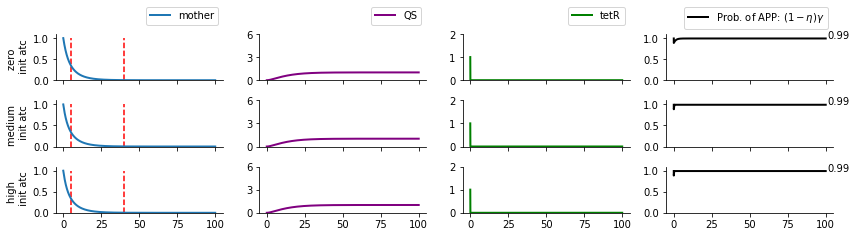

In [17]:
Ka=1e3
KQ=7e7
KR=1#1e-1 #for R1


NT=1e8
init_m=NT
init_d=NT-init_m
init_R=KR
init_R2=0
init_Q=0
KC=7
init_C=KC*np.array([0, 1, 2])

#ODE model parameters
g1= 0.27    #Mother cell   #(np.log(2)/20)*60   
g2= 0.14 #Daughter cell #(np.log(2)/25)*60
p1=0.1 #Quorum sensing mol
p2=0.05   #tetR
a1=0.01 # #QS leak
a2=0.01 # #tetR leak

q=3
a=5*Ka

k2p =6000#6e-12
k2m =0.06   
k3p =8.48e-1#6.58e-16
k3m =0.36#0.36  79.2  
k4p =1.43#1.43e-15
k4m =0.72   
k =1.19


T=100                                  
t = np.linspace(0, T, 10000)
f,axes = plt.subplots(3,4,figsize=(12,3.5))#,gridspec_kw={'width_ratios': [1, 1],'height_ratios': [3, 1,3,1]})
#f.text(0.45,1,'Model 3',fontsize=20)#f.text(0.45,1,'Leaky tetR',fontsize=20)
tag  =['zero \n init atc','medium \n init atc','high \n init atc']
for i in range(3):
    sol = solve_ivp(lambda t, z: leaky_cons_atc(t, z,a, Ka,KR,KQ,init_C[i],g1,g2,a1,a2,p1,p2,q,NT), [0, T], [init_m, init_d, init_Q, init_R,init_R2,0,0,0],dense_output=True)
    z1 = sol.sol(t)
    plot_model3(t,z1,a,i)
#f.savefig('leaky_atc_tetR.jpg', format='jpg', dpi=500,bbox_inches="tight")

In [ ]:
#z=[M,D,Q,R,R2,R3,R4,C] 
#  [0,1,2,3, 4, 5, 6,7]

plt.plot(t,z1[7]/KC)

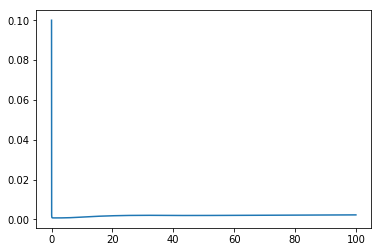

In [197]:
plt.plot(t,z1[3])

In [19]:
def leaky_cons_atc3(t,z,a,Ka,KR,KQ,KC,C0,g1,g2,a1,a2,p1,p2,q,NT):
    gamma=hill(z[3]/KR,q)   #z=[M,D,Q,R] [0,1,2,3]
    eta=hill(a/Ka,q)
    epsilon=hill(z[2]/KQ,q)
    zeta = hill(C0/KC,q)
    N1=g1*(1-(1-eta)*gamma)*z[0]-(g1*z[0]+g2*z[1])*(z[0]/(z[0]+z[1]))*np.heaviside(z[0]+z[1]-NT,0)
    N2=g1*(1-eta)*gamma*z[0]+g2*z[1]-(g1*z[0]+g2*z[1])*(z[1]/(z[0]+z[1]))*np.heaviside(z[0]+z[1]-NT,0)
    Q=(p1*(1-eta)*(1-a1)+p1*a1)*z[1]-(g1*z[0]+g2*z[1])*(z[2]/(z[0]+z[1]))*np.heaviside(z[0]+z[1]-NT,0)
    R2=0.5*(p2*(1-epsilon)*(1-a2)+p2*a2)-g1*z[3]-(2*k3p*k*C0*z[3])/(k+4*k3p*z[3])
    return [N1,N2,Q,R2]

def hill(x,q):
    return (1+x**q)**(-1)

def plot_model3(t,z1,a,i):
    axes[i,0].plot(t,z1[0]/NT,label='mother',color='C0',linewidth=2)
    #axes[i,0].plot(t,z1[1]/NT,label='daughter',color='C1')
    axes[i,0].set_ylabel(tag[i])
    axes[i,1].plot(t,z1[2]/KQ,label='QS',color='purple',linewidth=2)
    axes[i,2].plot(t,z1[3]/KR,label='tetR',color='green',linewidth=2) 
    gamma=hill(z1[3]/KR,q)   #z=[M,D,Q,R]
    eta=hill(a/Ka,q)
    prob=(1-eta)*gamma
    axes[i,3].plot(t,prob,label=r'Prob. of APP: $(1-\eta)\gamma$',color='k',linewidth=2)
    axes[i,3].text(T+1,prob[-1],"{:.2f}".format(prob[-1]),color='k')
    #print(((1-eta)*gamma)[-1])
    for j in range(4):
        axes[i,j].spines['right'].set_color('none')
        axes[i,j].spines['top'].set_color('none')
        if i<2:
            axes[i,j].set_xticklabels([])
        axes[i,j].set_xticks([0,T/2,T])
    axes[i,0].set_ylim([0,1.1])
    axes[i,0].set_yticks([0,0.5,1])
    axes[i,1].set_ylim([0,6])
    axes[i,1].set_yticks([0,3,6])
    axes[i,2].set_ylim([0,6])
    axes[i,2].set_yticks([0,3,6])
    axes[i,3].set_ylim([0,1.1])
    axes[i,3].set_yticks([0,0.5,1])
    if i==2:
        axes[0,0].legend(bbox_to_anchor=(1, 1.7),ncol=2)
        axes[0,1].legend(bbox_to_anchor=(1, 1.7),ncol=1)
        axes[0,2].legend(bbox_to_anchor=(1, 1.7),ncol=1)
        axes[0,3].legend(bbox_to_anchor=(1, 1.7),ncol=1)
    plt.tight_layout(h_pad=1,w_pad=1)
    return None

def plot_C0():
    plt.bar(tag,np.array(init_C)/KC,color='slategrey',width=0.5)
    ax = plt.gca()
    #ax.set_yscale('log')
    ax.set_ylabel(r'$\dfrac{C_0}{K_C}$', rotation=0)
    ax.hlines(1,-0.5,4,color='r')
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim([0,2])
    ax.set_yticks([0,1,2])
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    
    space=5
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        va = 'bottom'
        if y_value < 0:
            space *= -1
            va = 'top'
        label = "{:.1f}".format(y_value)
        ax.annotate(label,(x_value, y_value),xytext=(0, space),textcoords="offset points",ha='center',va=va)
    return None

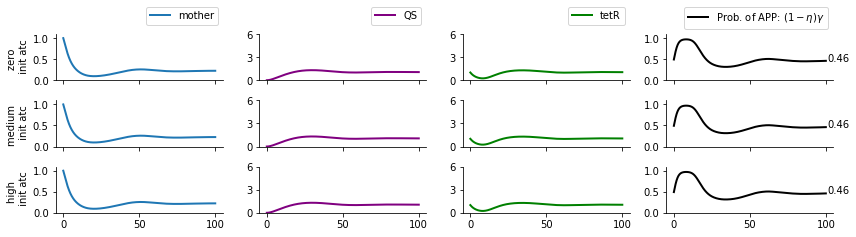

In [20]:
Ka=1e3
KQ=5e7
KR=5e-2 #for R1


NT=1e8
init_m=NT
init_d=NT-init_m
init_R=KR
init_R2=KR/2
init_Q=0
KC=8
init_C=KC*np.array([0, 1, 2])

#ODE model parameters
g1= 0.27  #Mother cell   #(np.log(2)/20)*60   
g2= 0.11 #Daughter cell #(np.log(2)/25)*60
p1=0.1 #Quorum sensing mol
p2=0.05   #tetR
a1=0.01 # #QS leak
a2=0.05 # #tetR leak

q=3
a=4*Ka

k2p =6e-12
k2m =0.06   #***
k3p =3.94e-12#6.58e-16
k3m =79.2#0.36   #*** 
k4p =1.43e-15
k4m =0.72   #***
k =1.19

T=100                                   
t = np.linspace(0, T, 10000)
f,axes = plt.subplots(3,4,figsize=(12,3.5))#,gridspec_kw={'width_ratios': [1, 1],'height_ratios': [3, 1,3,1]})
#f.text(0.45,1,'Model 3',fontsize=20)#f.text(0.45,1,'Leaky tetR',fontsize=20)
tag  =['zero \n init atc','medium \n init atc','high \n init atc']
for i in range(3):
    sol = solve_ivp(lambda t, z: leaky_cons_atc3(t, z,a, Ka,KR,KQ,KC,init_C[i],g1,g2,a1,a2,p1,p2,q,NT), [0, T], [init_m, init_d, init_Q, init_R],dense_output=True)
    z1 = sol.sol(t)
    plot_model3(t,z1,a,i)
f.savefig('leaky_atc_tetR3.jpg', format='jpg', dpi=500,bbox_inches="tight")

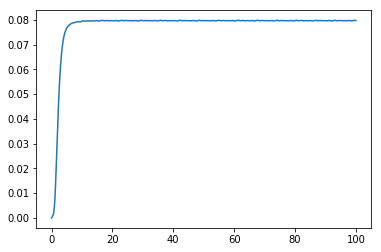

In [27]:
plt.plot(t,z1[3])